# SPARQL wrapper

We use a lightweight wrapper to make it possible to query ApertureDB in the RDF/SPARQL query language.  This wrapper makes it easy for users already familiar with the SPARQL query language to compose queries against an ApertureDB instance.

Note that SPARQL queries will be neither as powerful nor (necessarily) as efficient as writing queries in the [ApertureDB Query Language](https://docs.aperturedata.io/category/aperturedb-query-language)

In [ ]:
%pip install aperturedb-python rdflib

In [1]:
# We're going to use the pandas library to display binding sets in a more readable format.
import pandas as pd
pd.set_option('display.width', 200)
pd.set_option('display.max_colwidth', 50)

## Connect to ApertureDB

For the next part, we need access to a specific ApertureDB instance.
There are several ways to set this up.
The code provided here will accept ApertureDB connection information as a JSON string.
See our [Configuration](https://docs.aperturedata.io/Setup/client/configuration) help page for more options.

In [ ]:
! adb config create --from-json --active 

## Create SPARQL wrapper object

The first thing we need to do to use SPARQL is to create a wrapper object.
We're going to enable debug mode here, which makes the object cache some intermediate results so that we can take a peek under the covers.

In [3]:
from aperturedb.SPARQL import SPARQL
import json

# Create SPARQL object. We'll use the debugging feature to print interesting information.
sparql = SPARQL(debug=True)

## What happens when we create the wrapper?

This wrapper object has a connection to an ApertureDB instance.
It downloads the schema on creation, and sets up:
* Turtle namespaces
* A mapping from property URIs to the ApertureDB object types that use them
* A mapping from connection URIs to the ApertureDB objects that can be source and destination

### Namespaces

Namespaces are just a shorthand used in certain RDF serializations to make URLs shorter.
* The namespace `p:` can be used for ApertureDB property names.  For example, `p:name` means a property called `name`.
* The namespace `c:` can be used for ApertureDB connection classes.  For example `c:HasIngredient` refers to the connection class `HasIngredient`.

This is usually all you need to know, but here is a list of all namespaces created.
You'll see that every object class (e.g. `o:Ingredient`) is also a namespace; this is used to generate URIs that correspond to ApertureDB's unique ids.

In [4]:

# Internal feature: You don't normally have to look at this
print("namespaces:", json.dumps({k: str(v) for k, v in sparql.namespaces.items()}, indent=2))


namespaces: {
  "t": "http://aperturedb.io/type/",
  "c": "http://aperturedb.io/connection/",
  "p": "http://aperturedb.io/property/",
  "o": "http://aperturedb.io/object/",
  "knn": "http://aperturedb.io/knn/",
  "Ingredient": "http://aperturedb.io/object/Ingredient/",
  "_Descriptor": "http://aperturedb.io/object/_Descriptor/",
  "_DescriptorSet": "http://aperturedb.io/object/_DescriptorSet/",
  "_Image": "http://aperturedb.io/object/_Image/"
}


### Properties

Every property in the schema becomes an RDF property in the `p` namespace.
In OWL terms, it's a functional data property.

Because it is possible for more than one object class to share the same property name,
each property is mapped to a set of object classes.
These indicate the possible domain types of the property.
Because we're using a very simple data example here, these sets happen to all have size one.
The range type is not indicated here.

In [5]:
# Internal feature: You don't normally have to look at this
print("properties:", json.dumps({sparql.graph.qname(k): str(v)
      for k, v in sparql.properties.items()}, indent=2))

properties: {
  "p:UUID": "{'Ingredient'}",
  "p:category": "{'Ingredient'}",
  "p:macronutrient": "{'Ingredient'}",
  "p:micronutrient": "{'Ingredient'}",
  "p:name": "{'Ingredient', '_Image'}",
  "p:other_names": "{'Ingredient'}",
  "p:subgroup": "{'Ingredient'}",
  "p:_label": "{'_Descriptor'}",
  "p:_dimensions": "{'_DescriptorSet'}",
  "p:_name": "{'_DescriptorSet'}",
  "p:Recipe%20URL": "{'_Image'}",
  "p:adb_image_height": "{'_Image'}",
  "p:adb_image_id": "{'_Image'}",
  "p:adb_image_sha256": "{'_Image'}",
  "p:adb_image_size": "{'_Image'}",
  "p:adb_image_width": "{'_Image'}",
  "p:caption": "{'_Image'}",
  "p:contributor": "{'_Image'}",
  "p:cuisine": "{'_Image'}",
  "p:id": "{'_Image'}",
  "p:location": "{'_Image'}",
  "p:type": "{'_Image'}"
}


### Connections

All connection classes in the schema also become RDF properties, but this time in the `c` namespace.
In OWL terms, these are non-functional object properties.

These properties are shown here with the domain and range constraints.


In [6]:
# Internal feature: You don't normally have to look at this
print("connections:", json.dumps({sparql.graph.qname(k): str(v)
      for k, v in sparql.connections.items()}, indent=2))

connections: {
  "c:HasIngredient": "({'_Image'}, {'Ingredient'})",
  "c:_DescriptorConnection": "({'_Descriptor'}, {'_Image'})",
  "c:_DescriptorSetToDescriptor": "({'_DescriptorSet'}, {'_Descriptor'})"
}


## Create query and run it

Now it's time for us to run a query.

Our first example is going to look for all images (dishes) that have both chicken and butter as ingredients.

The result of a SPARQL SELECT query is a set of binding sets.
We use a provided helper method to convert this into a Pandas Dataframe for display.
This automatically converts URIs into QNames.

In [7]:
# Find all images with chicken and butter as ingredients
query = """
SELECT ?s ?caption {
?s c:HasIngredient [p:name "chicken"] , [p:name "butter"] ;
    p:caption ?caption .
} LIMIT 10
"""

df = sparql.to_dataframe(sparql.query(query))
print(df)

                   s                                            caption
0  _Image:7.3.157380               Chicken in Creamy tomato based gravy
1  _Image:7.7.157380  Butter chicken, special fried rice, garlic naa...


### What about those images?

RDF/SPARQL is a text-based language and does not handle blobs.  The wrapper provides some utility methods `get_blob`, `get_image`, and `show_image` to handle images.  Currently these fetched from ApertureDB in a separate query, but a future version may provide automatic caching or batching.

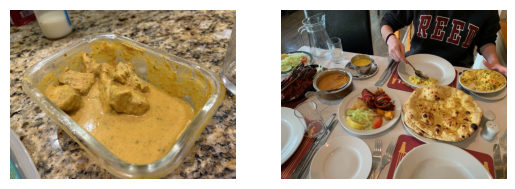

In [8]:
sparql.show_images(df.s)

## Under the covers

To implement this wrapper, ApertureDB is working with the rdflib SPARQL engine, adding a custom evaluation function.
Specifically, we are handling the "Basic Graph Pattern" (BGP) node in the SPARQL algebra.

### Triples

Under the covers, rdflib will parse the query and turn it into flattened triples.  Blank nodes get special identifiers.
This forms the input to ApertureDB's SPARQL wrapper.
This is what we see for the query above.

In [9]:
# Internal debug feature: Not available by default
print(sparql._format_triples(sparql.triples))

N28121daeb1314e298b639623ea6f556f p:name chicken .
N6b09f3b7d7b8490da0b2700869014922 p:name butter .
?s c:HasIngredient N28121daeb1314e298b639623ea6f556f .
?s c:HasIngredient N6b09f3b7d7b8490da0b2700869014922 .
?s p:caption ?caption


### ApertureDB query

When the wrapper is passed these triples, it converts them into an ApertureDB query.

Experienced SPARQL users might want to use this debug feature to order to learn how to use this language directly.

In [10]:
# Internal debug feature: Not available by default
print(json.dumps(sparql.input_query, indent=2))

[
  {
    "FindEntity": {
      "with_class": "Ingredient",
      "_ref": 1,
      "uniqueids": true,
      "constraints": {
        "name": [
          "==",
          "chicken"
        ]
      }
    }
  },
  {
    "FindEntity": {
      "with_class": "Ingredient",
      "_ref": 2,
      "uniqueids": true,
      "constraints": {
        "name": [
          "==",
          "butter"
        ]
      }
    }
  },
  {
    "FindImage": {
      "_ref": 3,
      "uniqueids": true,
      "is_connected_to": {
        "all": [
          {
            "ref": 1,
            "direction": "in",
            "connection_class": "HasIngredient"
          },
          {
            "ref": 2,
            "direction": "in",
            "connection_class": "HasIngredient"
          }
        ]
      },
      "group_by_source": true,
      "results": {
        "list": [
          "caption"
        ]
      }
    }
  }
]


### ApertureDB response

ApertureDB is then able to run the query and generate a response.

In [11]:
# Internal debug feature: Not available by default
print(json.dumps(sparql.output_response, indent=2))

[
  {
    "FindEntity": {
      "entities": [
        {
          "_uniqueid": "10.14.157420"
        }
      ],
      "returned": 1,
      "status": 0
    }
  },
  {
    "FindEntity": {
      "entities": [
        {
          "_uniqueid": "10.11.157420"
        }
      ],
      "returned": 1,
      "status": 0
    }
  },
  {
    "FindImage": {
      "entities": {
        "10.11.157420": [
          {
            "_uniqueid": "7.3.157380",
            "caption": "Chicken in Creamy tomato based gravy"
          },
          {
            "_uniqueid": "7.7.157380",
            "caption": "Butter chicken, special fried rice, garlic naan, peshwari naan"
          }
        ],
        "10.14.157420": [
          {
            "_uniqueid": "7.3.157380",
            "caption": "Chicken in Creamy tomato based gravy"
          },
          {
            "_uniqueid": "7.7.157380",
            "caption": "Butter chicken, special fried rice, garlic naan, peshwari naan"
          }
        ]
      

We then convert the query response into a set of solutions, each of which is a mapping of variables to values.

In [13]:
# Internal debug feature: Not available by default
solutions = [ {str(k): sparql._format_node(v) for k, v in solution.items()} for solution in sparql.solutions ]
print(len(solutions))
for solution in solutions:
    print(solution)

2
{'s': '_Image:7.7.157380', 'caption': 'Butter chicken, special fried rice, garlic naan, peshwari naan'}
{'s': '_Image:7.3.157380', 'caption': 'Chicken in Creamy tomato based gravy'}


## Another query

Before we asked for images with chicken AND butter as ingredients.
Now we're going to ask for chicken OR butter.
Note that we use the `VALUES` keyword in our SPARQL query.
This means that, under the covers, we're calling ApertureDB twice, once for each value, but rdflib's SPARQL engine handles that for us.

                    s                                            caption
0   _Image:7.3.157380               Chicken in Creamy tomato based gravy
1   _Image:7.7.157380  Butter chicken, special fried rice, garlic naa...
2  _Image:7.10.157380  won ton soup, chicken chow mein, chicken katsu...
3   _Image:7.3.157380               Chicken in Creamy tomato based gravy
4   _Image:7.7.157380  Butter chicken, special fried rice, garlic naa...
5  _Image:7.16.157380                                      fried lobster
6  _Image:7.22.157380           Buttery croissants with chocolate inside


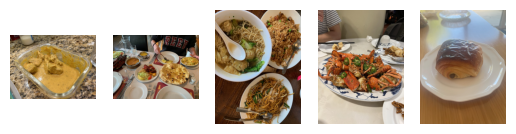

In [14]:
# Find all images with chicken or butter as ingredients
query = """
SELECT ?s ?caption WHERE {
VALUES ?ingredient { "chicken" "butter" }
?s c:HasIngredient [p:name ?ingredient] ;
    p:caption ?caption .
} LIMIT 10
"""

df = sparql.to_dataframe(sparql.query(query))
print(df)
sparql.show_images(df.s)

## One more query

Let's show off some more features of the SPARQL language.
Here we use `COUNT`, `GROUP BY`, and `ORDER BY`.
These are all being handled by the SPARQL engine, but a future integration might optimize them.

In [16]:
# Find the top 10 ingredients
query = """
SELECT (COUNT(*) AS ?count) ?ingredient WHERE {
?s c:HasIngredient [p:name ?ingredient] .
} GROUP BY ?ingredient ORDER BY DESC(?count) LIMIT 10
"""

df = sparql.to_dataframe(sparql.query(query))
print(df)

   count         ingredient
0      5                egg
1      4             butter
2      4            noodles
3      3  all-purpose flour
4      3            chicken
5      3               milk
6      3               rice
7      2           eggplant
8      2              sugar
9      2             potato


## KNN search

We've shown off how to use ApertureDB to answer graph queries using SPARQL, but ApertureDB is not just a graph database.
It integrates a high-performance vector store.
Again, SPARQL is not a good language for handling binary data,
but this integration provides support for descriptor search.

Doing descriptor search requires something like the following:

```python
?descriptor knn:search [
    knn:vector "[1,2,3,4,5]" ;   # vector for descriptor as a JSON string
    knn:set "RecipeEmbeddings" ; # descriptor set
    knn:k_neighbors 5 ;          # number of results
    knn:knn_first true ;         # optional
    knn:engine "HNSW" ;          # optional
    knn:metric "L2" ;            # optional
    knn:distance ?distance       # optional, binds to distance literals
] .
```

Here `?descriptor` is an ApertureDB `Descriptor`, and the object of `knn:search` specifies a search to be performed.

Here is an example query.
Note that we're using the helper method `encode_descriptor` to convert the vector into a JSON string.

In [17]:
import numpy as np
descriptor = np.random.rand(512)

query = f"""
SELECT ?i ?distance ?d ?caption WHERE {{
?d knn:similarTo [ 
    knn:set 'ViT-B/16' ; 
    knn:k_neighbors 20 ;
    knn:vector "{sparql.encode_descriptor(descriptor)}" ;
    knn:distance ?distance 
] ;
    c:ANY ?i . # Use fake connection because we can't say c:_DescriptorConnection
    ?i p:caption ?caption . 
}}
"""

Now we can run the query and get back images, descriptors, and distances.

In [18]:
df = sparql.to_dataframe(sparql.query(query))
print(df)

                     i    distance                        d                                            caption
0    _Image:7.7.157380  247.529144   _Descriptor:3.7.157380  Butter chicken, special fried rice, garlic naa...
1    _Image:7.5.157380  248.080185   _Descriptor:3.5.157380  Baked potato with Scottish Cheddar, Branston P...
2   _Image:7.25.157380  251.692139  _Descriptor:3.25.157380     Fresh homemade tortillas with egg and tomatoes
3   _Image:7.22.157380  255.406448  _Descriptor:3.22.157380           Buttery croissants with chocolate inside
4    _Image:7.3.157380  255.587692   _Descriptor:3.3.157380               Chicken in Creamy tomato based gravy
5    _Image:7.0.157380  256.033447   _Descriptor:3.0.157380                                    Beans with rice
6   _Image:7.28.157380  256.846130  _Descriptor:3.28.157380  Trader joes chocolate icecream with whipped cr...
7   _Image:7.15.157380  258.259705  _Descriptor:3.15.157380                                salmon, white beans
8

Finally we can show the images.

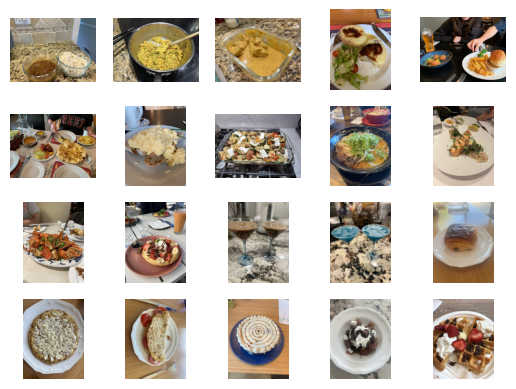

In [19]:
sparql.show_images(df.i)